<a href="https://colab.research.google.com/github/srilav/neuralnetwork/blob/main/Face_Mask_Detection_lalitha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini Project Notebook: Face Mask Detection using Convolutional Neural Networks

## Learning Objectives

At the end of the miniproject, you will be able to :

* load and extract features of images using ImageDataGenerator

* build the convolutional neural networks

* use the pre-trained models using keras applications

## Introduction

This project uses a Deep Neural Network, more specifically a Convolutional Neural Network, to differentiate between images of people, with masks, without masks and incorrectly placed masks. Manually built and pretrained networks will be used to perform this classification task.

**Face-Mask-Detection-Using-CNN**

* Outbreak of the Coronavirus pandemic has created various changes in the lifestyle of everyone around the world.
* Among these changes, wearing a mask has been very vital to every individual.
* Detection of people who are not wearing masks is a challenge due to the large populations.
* This face mask detection project can be used in schools, hospitals, banks, airports etc as a digitalized scanning tool. 
  - The technique of detecting people’s faces and segregating them into three classes namely the people with masks and people without masks and partial masks is done with the help of image processing and deep learning.
* With the help of this project, a person who is monitoring the face mask status for a particular firm can be seated in a remote area and still monitor efficiently and give instructions accordingly.

![img](https://d2h0cx97tjks2p.cloudfront.net/blogs/wp-content/uploads/sites/2/2020/07/dataset-with-mask-1536x844.png)

## Dataset

The data for this mini-project is collected from various sources including the masked images from internet and general frontal face images considered as without mask. This dataset consists of 5029 train images and 1059 test images with 3 classes `with_mask`, `without_mask` and `partial_mask`

Many people are not correctly wearing their masks due to bad practices, bad behaviors or vulnerability of individuals (e.g., children, old people). For these reasons, several mask wearing campaigns intend to sensitize people about this problem and good practices. In this sense, this work proposes three types of masked face detection dataset; namely, the Correctly Masked Face, the Incorrectly Masked Face and their combination for the global masked face detection. This dataset serves the objective of classifying faces that are: 
  
- Without Mask/ With Mask/ Partial Mask
  
Note that this dataset contains some annotated (artificially generated) masks to augment the 'masked' data category.

## Problem Statement

To build and implement a Convolutional Neural Network model to classify between masked/unmasked/partially masked faces.

## Grading = 10 Points

In [13]:
#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/MP2_FaceMask_Dataset.zip
!unzip -qq MP2_FaceMask_Dataset.zip
print("Data Downloaded Successfuly!!")

Data Downloaded Successfuly!!


### Import Required packages

In [14]:
import numpy as np
import PIL
from matplotlib import pyplot as plt
import glob, os
import tensorflow as tf
from tensorflow import keras
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout,InputLayer
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint

In [15]:
from PIL import Image
import pathlib
SEEDS = 42

np.random.seed(SEEDS)
tf.random.set_seed(SEEDS)

In [16]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [17]:
print(tf.__version__)

2.7.0


## Data Loading and preprocessing (2 points)

### Analyze the shape of images and distribution of classes

In [18]:
train_data_path = "/content/MP2_FaceMask_Dataset/train"

In [19]:
categories = os.listdir(train_data_path)
categories

['without_mask', 'with_mask', 'partial_mask']

In [20]:
labels=[i for i in range(len(categories))]
label_dict=dict(zip(categories,labels)) #dictionary
print(label_dict)
print(categories)
print(labels)

{'without_mask': 0, 'with_mask': 1, 'partial_mask': 2}
['without_mask', 'with_mask', 'partial_mask']
[0, 1, 2]


In [21]:
def label_extract():
  #image_size = 100
  image_path=[]
  labels = []
  for category in categories:
    folder_path = os.path.join(train_data_path,category)
    image_names = os.listdir(folder_path)
    for image_name in image_names:
      try:
        image_path.append(os.path.join(folder_path,image_name))
        labels.append(category)
      except:
        print("Error Loading Image")
  labels = np.array(labels)
  return image_path,labels

In [22]:
image_path,labels=label_extract()

In [23]:
image_path[0]

'/content/MP2_FaceMask_Dataset/train/without_mask/71.jpg'

JPEG
RGB
(160, 160)


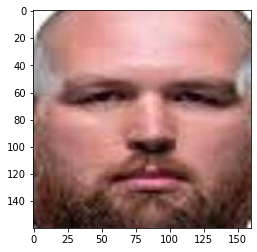

In [24]:
from PIL import Image
# load the image
image = Image.open(image_path[0])
# summarize some details about the image
print(image.format)
print(image.mode)
print(image.size)
# display the array of pixels as an image
plt.imshow(image)
plt.show()

In [25]:
target=np.array(labels)
target

array(['without_mask', 'without_mask', 'without_mask', ...,
       'partial_mask', 'partial_mask', 'partial_mask'], dtype='<U12')

In [26]:
# Checking for class bias
def check_target_class_bias():
  unique_labels, Label_count = np.unique(target, return_counts = True)
  print(np.asarray((unique_labels)))
  plt.bar( np.arange(3), Label_count, align='center',color='blue' )
  plt.xlabel('Class')
  plt.ylabel('No of Training data files')
  plt.xlim([-1, 4])

  plt.show()

['partial_mask' 'with_mask' 'without_mask']


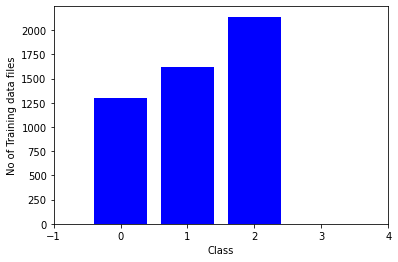

In [27]:
check_target_class_bias()

### Load the images using ImageDataGenerator

There are two main steps involved in creating the generator.
1. Instantiate ImageDataGenerator with required arguments to create an object
2. Use the `flow_from_directory` command depending on how your data is stored on disk. This is the command that will allow you to generate and get access to batches of data on the fly.

Hint: [link](https://keras.io/api/preprocessing/image/)

tf.keras.preprocessing.image.ImageDataGenerator
Generate batches of tensor image data with real-time data augmentation.

The ImageDataGenerator class has three methods flow(), flow_from_directory() and flow_from_dataframe() to read the images from a big numpy array and folders containing images


Calling image_dataset_from_directory(main_directory, labels='inferred') will return a tf.data.Dataset that yields batches of images from the subdirectories class_a and class_b, together with labels 0 and 1 (0 corresponding to class_a and 1 corresponding to class_b).

Supported image formats: jpeg, png, bmp, gif. Animated gifs are truncated to the first frame

In [28]:
TRAINING_DIR = "/content/MP2_FaceMask_Dataset/train/"
VALIDATION_DIR = "/content/MP2_FaceMask_Dataset/test/"
nb_train_samples = 5029
nb_validation_samples = 1259
batch_size=32
# dimensions of our images.
img_width, img_height = 256, 256


In [29]:
train_datagen = ImageDataGenerator(
   rescale = 1./255,
        shear_range = 0.1,
        zoom_range = [0.8, 1.25],
        brightness_range = [0.5,1],
        height_shift_range = 0.1,
        width_shift_range = 0.1,
        rotation_range = 0.12,
        horizontal_flip=True
        )
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        TRAINING_DIR ,
        seed=42,
        classes=['partial_mask', 'with_mask', 'without_mask'],
        shuffle=True,
        target_size=(256, 256),
        batch_size=32,
        subset=None,
        interpolation='nearest',
        color_mode="rgb",
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        VALIDATION_DIR,
        seed=42,
        classes=['partial_mask', 'with_mask', 'without_mask'],
        shuffle=True,
        target_size=(256, 256),
        batch_size=32,
        subset=None,
        interpolation='nearest',
        color_mode="rgb",
        class_mode='categorical')

Found 5029 images belonging to 3 classes.
Found 1259 images belonging to 3 classes.


In [30]:
train_generator.image_shape

(256, 256, 3)

In [31]:
type(train_generator)

keras.preprocessing.image.DirectoryIterator

Actually, you should set the “batch_size” in both train and valid generators to some number that divides your total number of images in your train set and valid respectively, but this doesn’t matter before because even if batch_size doesn’t match the number of samples in the train or valid sets and some images gets missed out every time we yield the images from generator, it would be sampled the very next epoch you train.

In [32]:
batch_size = 5029
img_height = 256 #Default
img_width = 256
train_ds = tf.keras.utils.image_dataset_from_directory(
  TRAINING_DIR,
  labels='inferred',
  label_mode= 'categorical',
  class_names=['partial_mask', 'with_mask', 'without_mask'],
  color_mode='rgb',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=5031)

Found 5031 files belonging to 3 classes.


In [33]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [34]:
batch_size = 1259
img_height = 256 #Default
img_width = 256
val_ds = tf.keras.utils.image_dataset_from_directory(
  VALIDATION_DIR,
  labels='inferred',
  label_mode= 'categorical',
  class_names=['partial_mask', 'with_mask', 'without_mask'],
  color_mode='rgb',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1260 files belonging to 3 classes.


In [35]:
class_names = train_ds.class_names
print(class_names)

['partial_mask', 'with_mask', 'without_mask']


### Visualize the sample images of each class using data generator

Hint: plt.subplot

In [36]:
import random
DATASET_FOLDER='/content/MP2_FaceMask_Dataset/train'
def plot_sample_image():
  f = plt.figure(figsize=(6,6))
  classes = 3
  image={}
  cur_path = DATASET_FOLDER
  for i in range(len(categories)):
    s = f.add_subplot(3, 3, i+1)
    s.axis('Off')
    sample = random.choice(image_path)
    image[i]=Image.open(sample)
    #image[i] = image.resize((100,100))
    plt.imshow(image[i])
  plt.show()

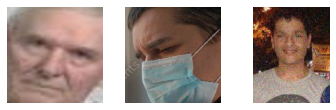

In [37]:
plot_sample_image()

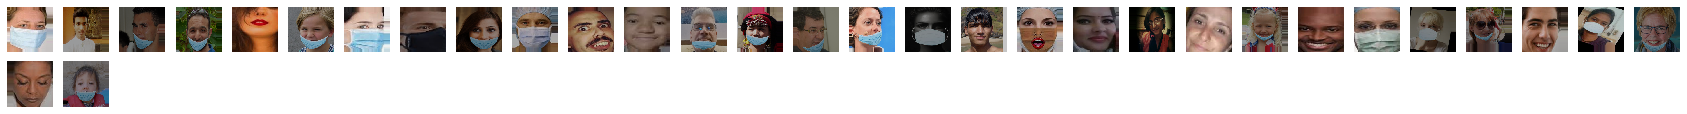

In [38]:
def plots(ims, figsize=(30,30), rows=3, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(30, 30, i+1)
        sp.axis('Off')
        plt.imshow(ims[i], interpolation=None if interp else 'none')

imgs, labels = next(train_generator)

plots(imgs)

In [39]:
for image_batch, labels_batch in validation_generator:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32, 3)


In [40]:
for image_batch, labels_batch in train_generator:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32, 3)


## Build the CNN model using Keras (4 points)



**Convolutional Neural Network:** A neural network in which at least one layer is a convolutional layer. A typical convolutional neural network consists of some combination of the following layers:

* convolutional layers
* pooling layers
* dense layers


**Conv2D**  

Passing an image with input shape of 3-D and to calculate the output: 

 $O = \frac{n - f + 2p}{s} + 1$

**MaxPool** 

The resulting output, when using the "valid" padding option, has a spatial shape (number of rows or columns) of: 

O = `math.floor`$(\frac{input shape - pool size)}{ strides}) + 1$ (when input shape >= pool size)

The resulting output shape when using the "same" padding option is: 

O = `math.floor`$(\frac{input shape - 1}{strides}) + 1$

by default, stride = None, so stride is same as pool size

Task-flow
* Initialize the network of convolution, maxpooling and dense layers
* Define the optimizer and loss functions
* Fit the model and evaluate the model

In [41]:
train_generator.image_shape

(256, 256, 3)

In [42]:
# Create model
# Input size - 256*256*64(RGB)
# 1000 filters * 3*3*64(size)
# 256*256*1000
# padding = same .  No change in dimensions.  Width and height.
#depth -No of filters .. smooth, edge,  ...

model = Sequential([
                    Conv2D(64, 3, activation="relu", padding="same", input_shape=[256, 256, 3]),
                    Conv2D(64, 3, activation="relu", padding="same"),
                    MaxPooling2D(2),
                    BatchNormalization(),
                    Conv2D(128, 3, activation="relu", padding="same"),
                    Conv2D(128, 3, activation="relu", padding="same"),
                    MaxPooling2D(2),
                    BatchNormalization(),
                    Conv2D(256, 3, activation="relu", padding="same"),
                    Conv2D(256, 3, activation="relu", padding="same"),
                    MaxPooling2D(2),
                    BatchNormalization(),
                    Conv2D(256, 3,activation="relu", padding="same"),
                    Conv2D(256, 3,strides=2,  activation="relu", padding="same"),
                    MaxPooling2D(2),
                    BatchNormalization(),
                    Flatten(),
                    Dense(128, activation="relu"),
                    Dropout(0.1),
                    Dense(64, activation="relu"),
                    Dropout(0.2),
                    Dense(3, activation="softmax")
                    ])

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 128)     1

In [44]:
# Compile model
from tensorflow.keras.optimizers import SGD, Adam
adam = Adam(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])

In [45]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_model.h5",save_best_only=True)

In [46]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size
model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=8,
          callbacks=[checkpoint_cb,early_stopping_cb ])

Epoch 1/8
157/157 [==============================] - 185s 1s/step - loss: 0.3355 - accuracy: 0.8721 - val_loss: 2.4093 - val_accuracy: 0.4223
Epoch 2/8
157/157 [==============================] - 161s 1s/step - loss: 0.1620 - accuracy: 0.9458 - val_loss: 2.2391 - val_accuracy: 0.5978
Epoch 3/8
157/157 [==============================] - 163s 1s/step - loss: 0.1257 - accuracy: 0.9596 - val_loss: 1.5163 - val_accuracy: 0.7003
Epoch 4/8
157/157 [==============================] - 163s 1s/step - loss: 0.1055 - accuracy: 0.9650 - val_loss: 0.0998 - val_accuracy: 0.9567
Epoch 5/8
157/157 [==============================] - 163s 1s/step - loss: 0.1026 - accuracy: 0.9644 - val_loss: 0.4571 - val_accuracy: 0.8502
Epoch 6/8
157/157 [==============================] - 165s 1s/step - loss: 0.0905 - accuracy: 0.9698 - val_loss: 0.0707 - val_accuracy: 0.9800
Epoch 7/8
157/157 [==============================] - 159s 1s/step - loss: 0.0896 - accuracy: 0.9720 - val_loss: 0.1207 - val_accuracy: 0.9615
Epoch 

In [47]:
model.evaluate_generator(generator=validation_generator,steps=STEP_SIZE_VALID)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[0.08661601692438126, 0.9751602411270142]

In [48]:
score = model.evaluate_generator(validation_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Test loss: 0.08634224534034729
Test accuracy: 0.9753772616386414


## Transfer learning (4 points)

Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

For eg. Using VGG16, we remove the last layer which takes a probability for each of the 1000 classes in the ImageNet and replaces it with a layer that takes 3 probabilities in our case.

When we train a CNN on image data, It is seen that top layers of the network learn to extract general features from images such as edges, distribution of colours, etc. As we keep going deep in the network, the layers tend to extract more specific features. Now we can use these pretrained models which already know how to extract features and avoid the training from scratch. This concept is known as transfer learning

### Use the pre-trained models ([VGG16](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16) or [ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50))

* Load the pre-trained model
* Fit and evaluate the data

Hint: [How to use pre-trained model](https://towardsdatascience.com/step-by-step-guide-to-using-pretrained-models-in-keras-c9097b647b29)

Task-flow
* Initialize the network with the weights of Imagenet
* Fine tune the network by modifying fully connected layers.
* Re-train the model with our problem data

In [49]:
from keras.applications.vgg16 import VGG16

pt_model = keras.models.Sequential()
VGG = VGG16(include_top=False, input_shape=(256,256,3))

for layer in VGG.layers[:13]:
    layer.trainable = False

pt_model.add(VGG)
pt_model.add(Flatten())
pt_model.add(Dense(3))

pt_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_3 (Dense)             (None, 3)                 98307     
                                                                 
Total params: 14,812,995
Trainable params: 9,537,539
Non-trainable params: 5,275,456
_________________________________________________________________


In [50]:
# Compile model
pt_model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])

In [ ]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size
pt_model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10)

Epoch 1/10
157/157 [==============================] - 142s 871ms/step - loss: 8.8745 - accuracy: 0.3820 - val_loss: 9.3118 - val_accuracy: 0.4223
Epoch 2/10
157/157 [==============================] - 136s 864ms/step - loss: 9.2864 - accuracy: 0.4239 - val_loss: 9.2860 - val_accuracy: 0.4239
Epoch 3/10
157/157 [==============================] - 138s 879ms/step - loss: 9.2606 - accuracy: 0.4255 - val_loss: 9.2860 - val_accuracy: 0.4239
Epoch 4/10
157/157 [==============================] - 138s 877ms/step - loss: 9.2606 - accuracy: 0.4255 - val_loss: 9.2989 - val_accuracy: 0.4231
Epoch 5/10
157/157 [==============================] - 139s 881ms/step - loss: 9.2831 - accuracy: 0.4241 - val_loss: 9.2731 - val_accuracy: 0.4247
Epoch 6/10
157/157 [==============================] - 137s 871ms/step - loss: 9.2638 - accuracy: 0.4253 - val_loss: 9.2860 - val_accuracy: 0.4239
Epoch 7/10
157/157 [==============================] - 138s 878ms/step - loss: 9.2638 - accuracy: 0.4253 - val_loss: 9.2989 -

In [ ]:
from tensorflow.keras.applications import ResNet50

rn_model = keras.models.Sequential()

RN = ResNet50(include_top=False, input_shape=(256,256,3))

for layer in RN.layers[:10]:
    layer.trainable = False

rn_model.add(RN)
rn_model.add(Flatten())
rn_model.add(Dense(3))

rn_model.summary()

In [ ]:
# Compile model
rn_model.compile(loss="categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [ ]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size
rn_model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=5)

In [ ]:
from keras.applications.vgg16 import VGG16
model=keras.models.Sequential()
model.add(VGG16(weights='imagenet'))
model.summary()

In [ ]:
def pretrain_model():
    model = keras.models.Sequential()
    model.add(VGG16(include_top=False,input_shape=(256, 256, 3)))
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.summary()
    return model

In [ ]:
inp = Input(shape=(224,224,3))
out=VGG16(weights='imagenet')(inp)
model=Model(inputs=inp,outputs=out)
model.summary()


#### Expected accuracy: More than 90%

### Capture the live image using the below code cell and predict

In [ ]:
#@title Capture the photo
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  display(Image(filename))
except Exception as err:
  print(str(err))

After executing above cell and capturing the photo, load the captured photo and predict with model.

**Note:** 
* Convert the image to numpy array and resize to the shape which model accept. 
* Extend the dimension (to 4-D shape) of an image, as the model is trained on a batch of inputs.

In [ ]:
features = PIL.Image.open("photo.jpg")
plt.imshow(features);
# to predict the image


### Instructions for preparing Kaggle competition predictions

Important: Refer the [Kaggle Team Creation Instructions Doc](https://drive.google.com/file/d/1NwUrRFpGuSagueS_BwGNq4upnyagTDxb/view?usp=sharing) 

* Load the image paths from Kaggle testset using `glob`
* Read the Images using `PIL.Image.open` and resize to required shape.
* Get the predictions using trained model and prepare a csv file
  - FC layer of DeepNet model gives output for each class, consider the maximum value among all classes as prediction using `np.argmax`.
* Predictions (csv) file should contain 2 columns as Sample_Submission.csv
  - First column is the img_path which is considered as index
  - Second column is prediction in decoded form (for eg. with_mask, partial_mask, without_mask).



In [12]:
STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size
validation_generator.reset()
pred=model.predict_generator(validation_generator,
steps=STEP_SIZE_TEST,
verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


ValueError: ignored

In [ ]:
predicted_class_indices=np.argmax(pred,axis=1)

In [ ]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [ ]:
#create data into submission csv
filenames = k_test_generator.filenames
results = pd.DataFrame({"img_path":filenames,"label":predictions})
results.to_csv("Sample_Submission.csv",index=False)

### Report Analysis

- Compare the accuracies for the Pre-trained vs CNN models
- What process was followed to tune the hyperparameters?
- Which model detects the mask/no mask/ partial mask more accurately with the live pictures?
- Discuss the confusion matrix in terms of the misclassifications